In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import matplotlib.pylab as plt
import itertools
import csv

In [ ]:
# def txt_to_data(filename): #CHANGES DEPENDING ON THE FILE
#     with open(filename, 'r') as file: # open file
#         lines = file.readlines()[1:]
#     my_db = [] # create empty list, db is going to be list of lists
#     # Text-preprocessing
#     for line in lines:
#         newline = " ".join(line.split()) # get rid of extra spaces 
#         newline = newline.split(',') # have list of TID [0-index] and rest are items
#         newline = [i for i in newline if i]
#         my_db.append(newline) #append to my_db
#     return my_db

def txt_to_data(filename): 
    with open(filename, 'r') as file: # open file
        lines = file.readlines()[1:] # keep all the lines except for 1st line?
    my_db = [] # create empty list, db is going to be list of lists
    # Text-preprocessing
    for line in lines:
        newline = " ".join(line.split(',')) # get rid of commas
        newline = " ".join(newline.split()) # get rid of extra spaces 
        newline = newline.split(' ') # have list of TID [0-index] and rest are items
        my_db.append(newline) #append to my_db
    return my_db

def csv_to_data(filename):
    my_db = []
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            my_db.append(list(filter(None, row)))
    return my_db

In [ ]:
def count_item_frequency(database): # CREATE COUNTER, Increment Number of Frequencies for each item
    counter = {}
    for trans in database: # go through every TID
      for i in range(1, len(trans)): # Every element besides the TID
        counter[trans[i]] = 1 + counter.get(trans[i], 0) # use get if adding item for the first time
    # REARRANGE IN DESCENDING ORDER
    rearranged_items =  dict(sorted(counter.items(), key=lambda item: item[1], reverse=True)) #rearranges counter based on minimum supports
    # print(rearranged_items)
    return rearranged_items

In [ ]:
class FPNode:
  def __init__(self, name, count=0, children=[], parent=None, next=None):
    self.name = name
    self.count = count
    self.children = children
    self.parent = parent
    self.next = next

  def insert_child(self, node):
    self.children.append(node)

  def insert_tree(self, p, node, itemHeaderTable, c): # c is necessary for fp conditional tree
    if node.children and any(p[0] == child.name for child in node.children): # check if node has children and node is in children
          for i, child in enumerate(node.children):
            if p[0] == child.name: # find the index of matching child name
              child_index = i 
              node.children[child_index].count += c # increment the child's count by c(1 for orignal fp tree)
              # print(node.children[child_index].name, node.children[child_index].count)
          n = node.children[child_index] # set n to the child with matching name
    else:
      n = FPNode(name=p[0], count=c, children=[], parent=self, next=None) # create node wtih count 1 and link to parent
      node.insert_child(n) # append to current node's children
      for item in itemHeaderTable:
        if item.name == n.name: # if name matches to item ID in headertable, make link
          cur = item
          while cur.next:
            cur = cur.next
          cur.next = n # link to Node link structure
    p.pop(0)
    if p: # if p is nonempty
      n.insert_tree(p, n, itemHeaderTable, c) # remaining of original list, existing child N or new node N

# mine FP_tree, implementation of FP_growth
  def fp_growth(self, tree, pattern, itemHeaderTable, minSup): 
    # Conditional Pattern Base, treat as a transacation database
    cpb = {}
    for item in reversed(itemHeaderTable): # start from length-1
      cur = item.next # get first node of node link
      mining = cur.parent # get parent of first node 
      while cur: # finds path of all node-links
        path = [] # creating prefix path, traversing upwards from the node
        while mining.name != "null": # check if not at root
          path.append(mining.name)
          mining = mining.parent # traverse upwards
        if path: # if a path was created
          path = tuple(reversed(path)) # reverse the path to get correct conditional pattern base
          newPrefix = {path : cur.count} # make HashMap for every prefix path
          if item.name not in cpb: # if item not a key in conditional pattern base
            cpb[item.name] = list()
          cpb[item.name].append(newPrefix) # add to conditional pattern base
        cur = cur.next # go to next node link
        if cur:
          mining = cur.parent # go to next parent
    print("Conditional Pattern Base\n") 
    for item, beta in cpb.items():
      print(f"{item} {beta}")
      
    # Conditional FP-tree
    print("\nConditional FP-tree")
    conDict = {}  # Create HashMap of Item:Conditional FP-Tree (will be used when genereating frequent patterns)
    for item, beta in cpb.items(): 
      conCounter = {} # Make counter for item in path of CPB
      nodes = set()
      conRoot = FPNode(name="null", count=None, children=[], parent=None, next=None) # root of conditonal FPTree
      for path in beta: # Counter built here
        for p, c in path.items():
          for node in p:
            conCounter[node] = c + conCounter.get(node, 0)
            nodes.add(node)
      for path in beta: # Build condtional FP-Trees here and add to conList
        for p, c in path.items():
          for node in p:
            thresholdList = [k for (k,v) in conCounter.items() if v >= minSup]
            pList = list(nodes)
          pList = [node for node in p if node in thresholdList]
          if pList:
            conRoot.insert_tree(pList, conRoot, itemHeaderTable, c) # pList is remaining list
          # add conRoot(con tree) to coressponding item in conList
      conDict.setdefault(item, []).append(conRoot)
      print(f"\n{item}", end=" ") # print out FP-tree and children
      for child in conRoot.children:
        print("<", end="") 
        conFPTreePrint = conRoot.printConFPTree(child)
        for i in range(len(conFPTreePrint)- 1):
          print(f"{conFPTreePrint[i].name}:{conFPTreePrint[i].count},", end="")
        print(f"{conFPTreePrint[-1].name}:{conFPTreePrint[-1].count}>", end="")
    # print out conDict
    print("\n\nFrequent Patterns Generated\n")
    for i, v in conDict.items(): # i item, v list of fp con trees
      print(f"{i} ", end="")
      newPatterns = {} # Generate new patterns, new frequent itemsets
      for tree in v:
        for child in tree.children:
          path = {}
          stack = [child]
          while stack:
            temp = stack.pop()
            path[child.name] = child.count  
            for child in temp.children[::-1]:
              stack.append(child)
          #print(path)
          for L in range(1, len(path) + 1):
            for subset in itertools.combinations(path.keys(), L): # Create all combinations to append to the item
              minCount = float('inf')
              for node in subset:
                minCount = min(minCount, path[node])
              subset += (i,)
              newPatterns[subset] = minCount + newPatterns.get(subset, 0) 
        print(newPatterns)

# Displaying Tree 
  def __str__(self, level=0):
      ret = "\t"*level+repr(self.name + ":" + str(self.count))+"\n"
      for child in self.children:
          ret += child.__str__(level+1)
      return ret
  def __repr__(self):
      return '<tree node representation>'

  def printConFPTree(self, root):
    if not root:
      return []
    stack = [root]
    out = []
    while stack:
      temp = stack.pop()
      out.append(temp)
      for child in temp.children[::-1]:
          stack.append(child)
    return out

In [ ]:
if __name__ == '__main__':
    # Enter a minimum support
    minSup = int(input("Input a minimum support value: "))
    # Create database from file/benchmark
    db = txt_to_data("/content/drive/MyDrive/Project1/textbook_ex.txt") # Create database, 'D'
    #db = txt_to_data("/content/drive/MyDrive/Project1/DataSetA.csv")
    print(db)

Input a minimum support value: 2
[['T100', 'I1', 'I2', 'I5'], ['T200', 'I2', 'I4'], ['T300', 'I2', 'I3'], ['T400', 'I1', 'I2', 'I4'], ['T500', 'I1', 'I3'], ['T600', 'I2', 'I3'], ['T700', 'I1', 'I3'], ['T800', 'I1', 'I2', 'I3', 'I5'], ['T900', 'I1', 'I2', 'I3']]


In [ ]:
    file_name = "/content/drive/MyDrive/Project1/DataSetA.csv"
    name = file_name.split('.')
    file_type = name[len(name)-1]
    if file_type == 'csv':
        db = csv_to_data(file_name)
    else:
        db = txt_to_data(file_name)

{'Bread': 4477, 'Ghee': 4468, 'Milk': 4459, 'Sweet': 4457, 'Coffee Powder': 4451, 'Lassi': 4436, 'Yougurt': 4430, 'Cheese': 4424, 'Butter': 4423, 'Panner': 4413, 'Sugar': 4398, 'Tea Powder': 4351}


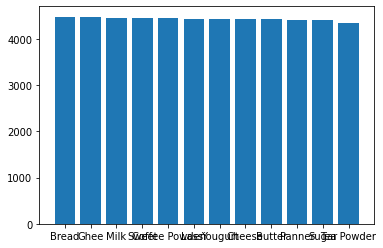

Streaming output truncated to the last 5000 lines.
['Tea Powder', 'Ghee', 'Sweet', 'Lassi', 'Yougurt', 'Cheese', 'Panner', 'Sugar']
['Milk', 'Lassi', 'Panner']
['Sweet', 'Ghee', 'Milk', 'Lassi', 'Cheese', 'Butter', 'Panner', 'Sugar']
['Yougurt', 'Bread', 'Sweet']
['Panner', 'Bread', 'Milk', 'Coffee Powder', 'Cheese', 'Butter']
['Bread', 'Milk', 'Sugar']
['Butter', 'Bread', 'Panner']
['Yougurt', 'Bread', 'Milk', 'Coffee Powder', 'Lassi', 'Panner']
['Lassi', 'Bread', 'Ghee', 'Sweet', 'Coffee Powder', 'Yougurt', 'Tea Powder']
['Cheese', 'Bread', 'Sweet', 'Coffee Powder', 'Sugar']
['Sweet', 'Bread', 'Ghee', 'Milk', 'Butter', 'Sugar']
['Milk', 'Coffee Powder', 'Panner']
['Sweet', 'Bread', 'Milk', 'Coffee Powder', 'Yougurt', 'Butter', 'Panner', 'Tea Powder']
['Sugar', 'Bread', 'Sweet', 'Coffee Powder', 'Butter', 'Tea Powder']
['Yougurt', 'Ghee', 'Sweet', 'Coffee Powder', 'Lassi', 'Butter', 'Panner', 'Sugar']
['Tea Powder', 'Ghee', 'Milk', 'Coffee Powder', 'Cheese']
['Bread', 'Cheese']
['Chee

In [ ]:
    # Create counter
    counter = count_item_frequency(db) 
    print(counter)
    lists = (counter.items()) # sorted by key, return a list of tuples #sorted() can let us sort keys
    # Bar graph of frequencies
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.bar(range(len(x)), y, tick_label=x) 
    plt.show() 
    for i, trans in enumerate(db):
      rearrange = sorted(trans[1:], key=lambda x: counter[x], reverse=True) #rearranges every transaction in descending order based on our sorted set of items
      db[i] = [trans[0]] + rearrange # sorted transacation
      print(db[i])
    #counter = {k:v for k,v in counter.items() if v >= minSup} # apply min threshold support on original counter

Item header table

In [ ]:
    # Node link structure
    itemHeaderTable = [] # Create header table (list of FPNodes and links)
    for item in counter.keys():
      itemHeaderTable.append(FPNode(name=item, count=None, children=[], parent=None, next=None))

In [ ]:
    # Create FP Tree
    root = FPNode(name="null", count=None, children=[], parent=None, next=None) # root of FPTree (named "null")
    for trans in db:
      p = trans[1:]
      root.insert_tree(p, root, itemHeaderTable, 1) # p is remaining list

In [ ]:
    print(str(root)) # print FP Tree

'null:None'
	'Ghee:2784'
		'Coffee Powder:395'
			'Yougurt:91'
				'Cheese:31'
					'Butter:5'
						'Tea Powder:1'
						'Panner:1'
							'Sugar:1'
						'Sugar:1'
							'Tea Powder:1'
					'Tea Powder:5'
					'Panner:10'
						'Sugar:2'
							'Tea Powder:1'
						'Tea Powder:3'
					'Sugar:2'
						'Tea Powder:1'
				'Butter:29'
					'Tea Powder:4'
					'Panner:11'
						'Sugar:7'
							'Tea Powder:2'
						'Tea Powder:2'
					'Sugar:3'
				'Sugar:8'
					'Tea Powder:4'
				'Tea Powder:4'
				'Panner:7'
					'Sugar:3'
						'Tea Powder:3'
			'Lassi:135'
				'Butter:26'
					'Sugar:6'
						'Tea Powder:3'
					'Tea Powder:3'
					'Panner:14'
						'Sugar:6'
							'Tea Powder:4'
						'Tea Powder:5'
				'Cheese:31'
					'Butter:13'
						'Sugar:5'
							'Tea Powder:4'
						'Panner:3'
							'Sugar:1'
								'Tea Powder:1'
						'Tea Powder:3'
					'Panner:10'
						'Sugar:4'
							'Tea Powder:1'
						'Tea Powder:1'
					'Sugar:4'
						'Tea Powder:3'
				'Yougurt:57'
					'Bu

In [ ]:
    # Print item header table node link structure
    for item in itemHeaderTable:
      print(f"Item ID: {item.name}")
      cur = item.next
      while cur:
        print(cur)
        cur = cur.next

Streaming output truncated to the last 5000 lines.

'Sugar:2'
	'Tea Powder:1'

'Sugar:13'
	'Tea Powder:4'

'Sugar:3'

'Sugar:6'
	'Tea Powder:3'

'Sugar:10'
	'Tea Powder:4'

'Sugar:12'
	'Tea Powder:4'

'Sugar:11'
	'Tea Powder:4'

'Sugar:6'
	'Tea Powder:3'

'Sugar:4'
	'Tea Powder:2'

'Sugar:1'

'Sugar:7'
	'Tea Powder:4'

'Sugar:10'
	'Tea Powder:3'

'Sugar:4'
	'Tea Powder:2'

'Sugar:13'
	'Tea Powder:6'

'Sugar:7'
	'Tea Powder:4'

'Sugar:16'
	'Tea Powder:5'

'Sugar:5'
	'Tea Powder:2'

'Sugar:1'

'Sugar:12'
	'Tea Powder:2'

'Sugar:8'
	'Tea Powder:3'

'Sugar:2'
	'Tea Powder:1'

'Sugar:9'
	'Tea Powder:4'

'Sugar:2'

'Sugar:4'
	'Tea Powder:3'

'Sugar:7'
	'Tea Powder:1'

'Sugar:12'
	'Tea Powder:4'

'Sugar:6'
	'Tea Powder:2'

'Sugar:1'
	'Tea Powder:1'

'Sugar:6'
	'Tea Powder:1'

'Sugar:5'

'Sugar:10'
	'Tea Powder:2'

'Sugar:5'

'Sugar:6'
	'Tea Powder:2'

'Sugar:8'
	'Tea Powder:3'

'Sugar:5'
	'Tea Powder:3'

'Sugar:6'
	'Tea Powder:2'

'Sugar:9'
	'Tea Powder:6'

'Sugar:1'

'Sugar:5'
	'Tea Powder:3

In [ ]:
root.fp_growth(root, None, itemHeaderTable, minSup)

Conditional Pattern Base

Tea Powder [{('Cheese', 'Butter'): 4}, {('Bread', 'Coffee Powder', 'Butter', 'Panner'): 2}, {('Ghee', 'Milk', 'Sweet', 'Panner'): 4}, {('Yougurt', 'Cheese', 'Butter', 'Sugar'): 3}, {('Bread', 'Sweet', 'Panner'): 5}, {('Ghee', 'Sweet', 'Coffee Powder', 'Lassi', 'Panner', 'Sugar'): 2}, {('Coffee Powder',): 22}, {('Sweet', 'Coffee Powder', 'Lassi', 'Sugar'): 6}, {('Milk', 'Lassi', 'Yougurt', 'Cheese', 'Butter'): 1}, {('Yougurt', 'Cheese', 'Sugar'): 4}, {('Ghee', 'Yougurt', 'Butter', 'Panner'): 3}, {('Bread', 'Coffee Powder'): 14}, {('Bread', 'Ghee', 'Butter', 'Panner'): 5}, {('Ghee', 'Milk', 'Coffee Powder', 'Lassi', 'Yougurt', 'Panner'): 3}, {('Bread', 'Coffee Powder', 'Lassi', 'Butter', 'Panner'): 2}, {('Ghee', 'Milk', 'Yougurt'): 6}, {('Bread', 'Ghee', 'Coffee Powder', 'Yougurt', 'Cheese'): 2}, {('Bread', 'Ghee', 'Coffee Powder', 'Lassi', 'Butter', 'Panner', 'Sugar'): 1}, {('Bread', 'Milk', 'Lassi', 'Butter', 'Panner', 'Sugar'): 2}, {('Milk', 'Sweet', 'Coffee 

Conditional Pattern Base

In [ ]:
#EX// 'I5' {{I2, I1, I3}:1, {I2, I1}:1}
#EX// 'I4' {{I2, I1}:1, {I2}:1}
#EX// 'I3' {{I2,I1}:2, {I2}:2, {I1}:2}
#EX// 'I1' {{I2}:4}

Conditional FP-tree

In [ ]:
#EX// 'I5' <I2:2, I1:2>
#EX// 'I4' <I2:2>
#EX// 'I3' <I2:4, I1:2> <I1:2>
#EX// 'I1' <I2:4>

Frequent Patterns Generated

In [ ]:
#EX// 'I5' {I2, I5}: 2, {I1, I5}: 2, {I2, I1, I5}: 2
#EX// 'I4' {I2, I4}: 2
#EX// 'I3' {I2,I3}: 4, {I1,I3}:4, {I2, I1, I3}: 2 
#EX// 'I1' {I1,I2}: 4 
